In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

### Exploratory Climate Analysis

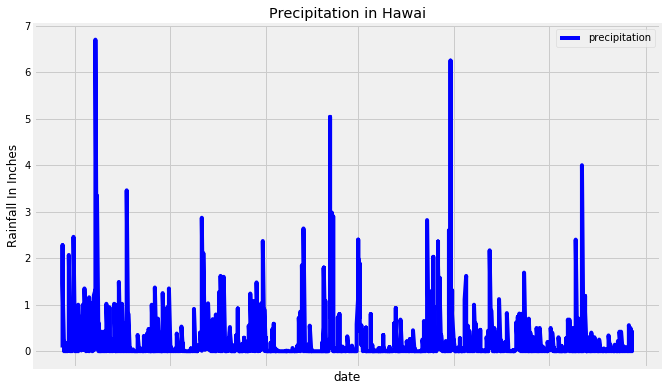

In [71]:
# Approach 1 : Start date and end dates  for the last 1 year data are specifically mentioned
import datetime as dt

qmain2="select date,prcp as precipitation from Measurement where date between '2016-08-24'and '2017-08-23' order by date "
df2=pd.read_sql(qmain2,session.bind)

df2.dropna(inplace=True)


df2['date'] =  pd.to_datetime(df2['date'])
df2=df2.set_index('date')
df2


fig, ax = plt.subplots(figsize=(10,7))
ax.tick_params(labelbottom=False) 
ax.set_title("Precipitation in Hawai")
ax.set_ylabel("Rainfall In Inches")
df2.plot(kind="line",ax=ax,color='blue')



In [74]:
df2.describe()

,precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


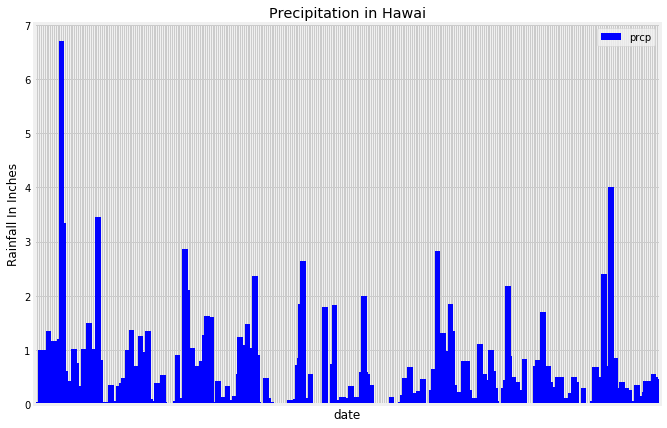

In [72]:
#Approach 2 : Using the pandas datetime functionality .last("<no_of_months>") and values are aggregated grouping by date
import datetime as dt

qmain="select date,prcp from Measurement group by date order by date"
df1=pd.read_sql(qmain,session.bind)
df1.dropna(inplace=True)

df1['date'] =  pd.to_datetime(df1['date'])

df1.head(20)
dfnew=df1.set_index('date').last('12M')

fig, ax = plt.subplots(figsize=(10,7))
ax.tick_params(labelbottom=False) 
ax.set_title("Precipitation in Hawai")
ax.set_ylabel("Rainfall In Inches")
dfnew.plot(kind="bar",ax=ax,color='blue',width=3)



In [75]:
dfnew.describe()

,prcp
count,337.000000
mean,0.419347
std,0.694500
min,0.000000
25%,0.010000
50%,0.140000
75%,0.550000
max,6.700000


In [16]:
# Design a query to show how many stations are available in this dataset?
q_st="select count (distinct station) from Measurement"
df_st=pd.read_sql(q_st,session.bind)
print(f"There are {df_st.values[0][0]} stations in the dataset")

There are 9 stations in the dataset


In [17]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
q_st2="select station,count(tobs) as `No Of Rows` from  Measurement group by station order by `No Of Rows` desc"
df_st2=pd.read_sql(q_st2,session.bind)
df_st2

,station,No Of Rows
0,USC00519281,2772
1,USC00519397,2724
2,USC00513117,2709
3,USC00519523,2669
4,USC00516128,2612
5,USC00514830,2202
6,USC00511918,1979
7,USC00517948,1372
8,USC00518838,511


In [76]:
#### TEST CODE
q_st3="select * from station"
df_st3=pd.read_sql(q_st3,session.bind)
df_st3.head(10)

### TEST CODE
def ret_start_date_end_date(start_date,end_date):      
    df2=pd.read_sql(f"select min(tobs) as TMIN,max(tobs) as TMAX,avg(tobs) as TAVG from measurement where date>='{start_date}' and date<='{end_date}'",session.bind)
    print(df2.to_dict())

##### TEST CODE
ret_start_date_end_date('2015-12-25','2016-05-25')

{'TMIN': {0: 56.0}, 'TMAX': {0: 82.0}, 'TAVG': {0: 71.57724425887265}}


In [21]:
# Determining the most active station
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?

most_active_st=df_st2['station'][0]
most_active_st

q_st4="select min(tobs),max(tobs),avg(tobs) from measurement where station='"+most_active_st+"'"
df_st4=pd.read_sql(q_st4,session.bind)

print(f"*****The most active station is {most_active_st}*****\nLowest Temp :  {df_st4.iloc[:,0:1].values[0][0]}\nHighest Temp : {df_st4.iloc[:,0:2].values[0][1]}\nAverage Temp : {df_st4.iloc[:,0:3].values[0][2]}")

*****The most active station is USC00519281*****
Lowest Temp :  54.0
Highest Temp : 85.0
Average Temp : 71.66378066378067


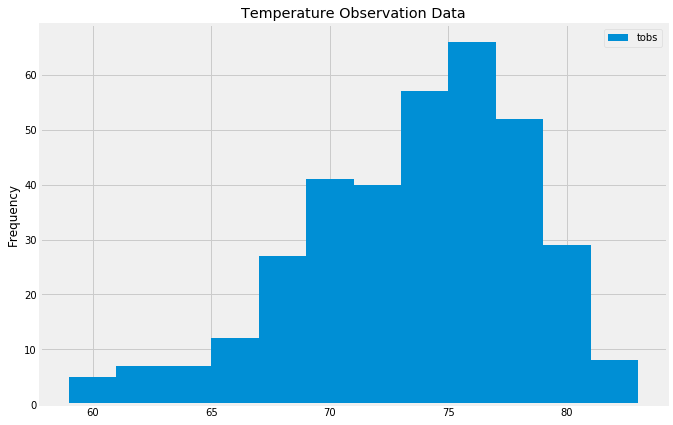

In [23]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
q_st5="select tobs from Measurement where station=='"+most_active_st+"'and date between '2016-08-24'and '2017-08-23' order by date "
df_st5=pd.read_sql(q_st5,session.bind)
df_st5['tobs']

n_bins=12
fig, ax = plt.subplots(figsize=(10,7))
ax.hist(df_st5['tobs'],bins=12)
ax.set_title("Temperature Observation Data")
ax.set_ylabel("Frequency")
ax.legend(['tobs'])



In [77]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date): 

    df_start_end=pd.read_sql(f"select min(tobs) as TMIN,max(tobs) as TMAX,avg(tobs) as TAVG from measurement where date>='{start_date}' and date<='{end_date}'",session.bind)  
   
    return df_start_end
# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

   TMIN  TMAX       TAVG
0  62.0  74.0  69.571429


In [78]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
print(calc_temps('2017-02-28', '2017-04-30'))

   TMIN  TMAX  TAVG
0  58.0  83.0  73.0


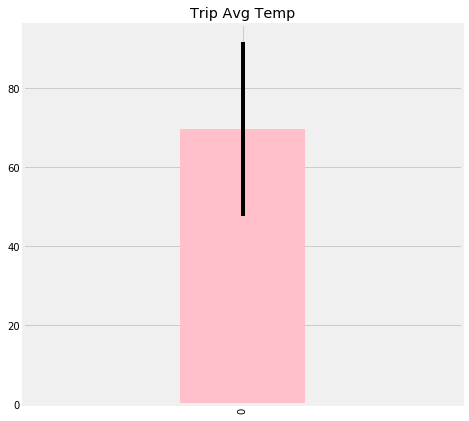

In [91]:
# Setting Trip Dates : 2017-01-01 TO 2017-02-15
# Calculating temperature min , max and avg from 01-Jan to 15-February of 2017

start_date='2017-01-01'
end_date='2017-02-15'

df_to_plot=calc_temps(start_date,end_date)

fig, ax = plt.subplots(figsize=(7,7))
ax.set_title("Trip Avg Temp")

df_to_plot['TAVG'].plot(kind="bar",ax=ax,color='pink',width=0.2,yerr=df_to_plot['TMAX']-df_to_plot['TMIN'])

In [98]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

q_st6=f"""select m.station,sum(m.prcp) as precipitation,s.name,s.longitude,s.latitude,s.elevation
         from Measurement as m
         join Station as s on m.station=s.station
         where m.date between '{start_date}' and '{end_date}' group by m.station order by precipitation desc"""
df_st6=pd.read_sql(q_st6,session.bind)
df_st6

,station,precipitation,name,longitude,latitude,elevation
0,USC00516128,11.93,"MANOA LYON ARBO 785.2, HI US",-157.80250,21.33310,152.4
1,USC00513117,7.91,"KANEOHE 838.1, HI US",-157.80150,21.42340,14.6
2,USC00519281,7.77,"WAIHEE 837.5, HI US",-157.84889,21.45167,32.9
3,USC00519523,7.75,"WAIMANALO EXPERIMENTAL FARM, HI US",-157.71139,21.33556,19.5
4,USC00514830,5.90,"KUALOA RANCH HEADQUARTERS 886.9, HI US",-157.83740,21.52130,7.0
5,USC00519397,3.86,"WAIKIKI 717.2, HI US",-157.81680,21.27160,3.0
6,USC00517948,0.05,"PEARL CITY, HI US",-157.97510,21.39340,11.9


## Optional Challenge Assignment

In [100]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
#     q_dl_normals = """SELECT MIN(tobs) AS TMIN, AVG(tobs) AS TAVG, MAX(tobs) AS TMAX
#             FROM measurement WHERE date LIKE '%"""+date+"""'"""
    
    q_dl_normals = f"""SELECT MIN(tobs) AS TMIN, AVG(tobs) AS TAVG, MAX(tobs) AS TMAX
                       FROM measurement WHERE date LIKE '%{date}'"""
    return pd.read_sql(q_dl_normals,session.bind)
    

    
daily_normals("01-02")

,TMIN,TAVG,TMAX
0,60.0,69.396226,77.0


In [103]:
# calculating the daily normals for my trip
start_date='2017-01-01'
end_date='2017-02-15'

start_date = dt.datetime.strptime(start_date, '%Y-%m-%d')
end_date = dt.datetime.strptime(end_date, '%Y-%m-%d')

delta = end_date - start_date

normals=pd.DataFrame()

for i in range(delta.days + 1):
    temp_df = daily_normals('{:%m-%d}'.format((start_date + dt.timedelta(i))))
    temp_df['date'] = str('{:%Y-%m-%d}'.format((start_date + dt.timedelta(i))))
    normals = normals.append(temp_df, sort=False)


normals = normals.set_index('date')
normals



,TMIN,TAVG,TMAX
date,,,
2017-01-01,62.0,69.153846,77.0
2017-01-02,60.0,69.396226,77.0
2017-01-03,62.0,68.909091,77.0
2017-01-04,58.0,70.000000,76.0
2017-01-05,56.0,67.964286,76.0
2017-01-06,61.0,68.964912,76.0
2017-01-07,57.0,68.543860,76.0
2017-01-08,57.0,67.160714,75.0
2017-01-09,58.0,67.929825,78.0


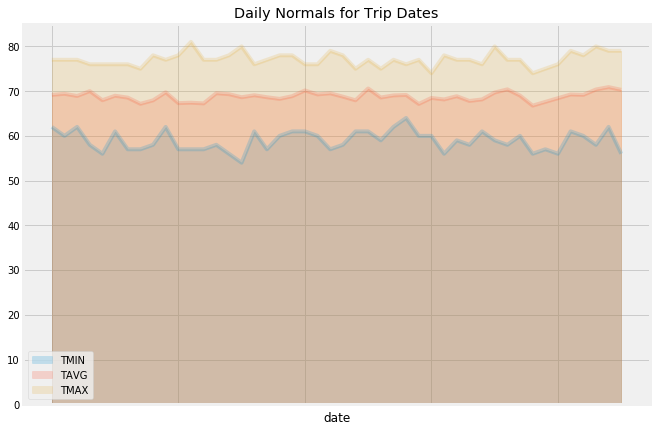

In [105]:
# Plot the daily normals as an area plot with `stacked=False`
fig, ax = plt.subplots(figsize=(10,7))
normals.plot(kind='area', ax=ax,alpha=.2, stacked=False, x_compat=True, title="Daily Normals for Trip Dates")